## EURECA 2025-12-05: JWST Point-Spread Function Modeling and Subtraction
#### Created by Meredith Stone for the Steward Observatory EURECA seminar

This notebook is a supplement to the PowerPoint presentation, and its main goal is to demonstrate the main factors that affect the shape of the JWST NIRCam PSF and should be accounted for when designing observations that will require PSF subtraction. To run this notebook, the ``stpsf`` package and its dependencies and required data files must be installed (see [the documentation](https://stpsf.readthedocs.io/en/latest/installation.html)). This is not an in-depth ``stpsf`` tutorial: see the documentation for demonstrations of the package.

In [1]:
import os

In [2]:
# replace with location of STPSF 
os.environ['WEBBPSF_PATH'] = '/home/meredithstone/anaconda3/envs/jwst/lib/python3.13/site-packages/stpsf/stpsf-data-LATEST/'

In [3]:
import stpsf

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ImageNormalize, LinearStretch, SqrtStretch, AsinhStretch, SinhStretch, ZScaleInterval, MinMaxInterval
from matplotlib.patches import Circle

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-072
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


The JWST PSF varies by four main mechanisms:
- variation with flux due to the brighter-fatter effect (not demonstrated in this notebook, as it is not built into STPSF)
- variation with time due to the telescope's changing wavefront (stochastic, but significant on timescales of days and longer)
- variation with the source's position on the detector due to the optical aberrations inherent to the detector itself
- variation with the shape of the source's spectrum across the observed filter

We'll walk through each of these in turn.

### Variation with flux: not demonstrated

STPSF automatically includes some distortion effects, including charge diffusion, interpixel capacitance, and post-pixel coupling. It does *not* include the brighter-fatter effect, where brighter sources have broader PSFs than fainter sources due to the electrons already present in the CCD pixel deflecting additional charges coming in. For more information about the brighter-fatter effect, see [Plazas et al. 2018](https://iopscience.iop.org/article/10.1088/1538-3873/aab820/meta) (NIR detectors) or [Argyriou et al. 2023](https://scixplorer.org/abs/2023A&A...680A..96A/abstract) (JWST/MIRI).

### Variation with time

JWST's wavefront changes stochastically with time as the primary mirror is impacted by micrometeoroids. This wavefront error is measured a few times a week and corrected 2+ times per month, but a) not all effects can be corrected out, and b) your observations might be taken after the deviation but before the correction. For JWST, STPSF allows simulation of PSFs using wavefronts measured on orbit: let's use this to compare two PSFs from July 2022.

On July 11th, 2022, a micrometeroid impact significantly impacted JWST's wavefront error. A correction was applied on July 15th, which restored the wavefront to baseline. Let's explore how the PSF changed during that time.

In [4]:
# initialize two instances of STPSF, here with NIRCam: one for a simulation of July 12th, one for July 16th
nrc_j12 = stpsf.NIRCam() # initialize july 12
nrc_j16 = stpsf.NIRCam() # initialize july 16
nrc_j12.filter = 'F200W'; nrc_j16.filter = 'F200W' # set the filter to simulate (doesn't profoundly matter which)

iterating query, tdelta=3.0

MAST OPD query around UTC: 2022-07-12T00:00:00.000
                        MJD: 59772.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2022071001-NRCA3_FP1-0.fits
	Date (MJD):	 59770.4830
	Delta time:	 -1.5170 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022071302-NRCA3_FP1-1.fits
	Date (MJD):	 59772.6632
	Delta time:	 0.6632 days
User requested choosing OPD time closest in time to 2022-07-12T00:00:00.000, which is R2022071302-NRCA3_FP1-1.fits, delta time 0.663 days
Importing and format-converting OPD from /home/meredithstone/data/stpsf-data/MAST_JWST_WSS_OPDs/R2022071302-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point (NRCA3_FP1)


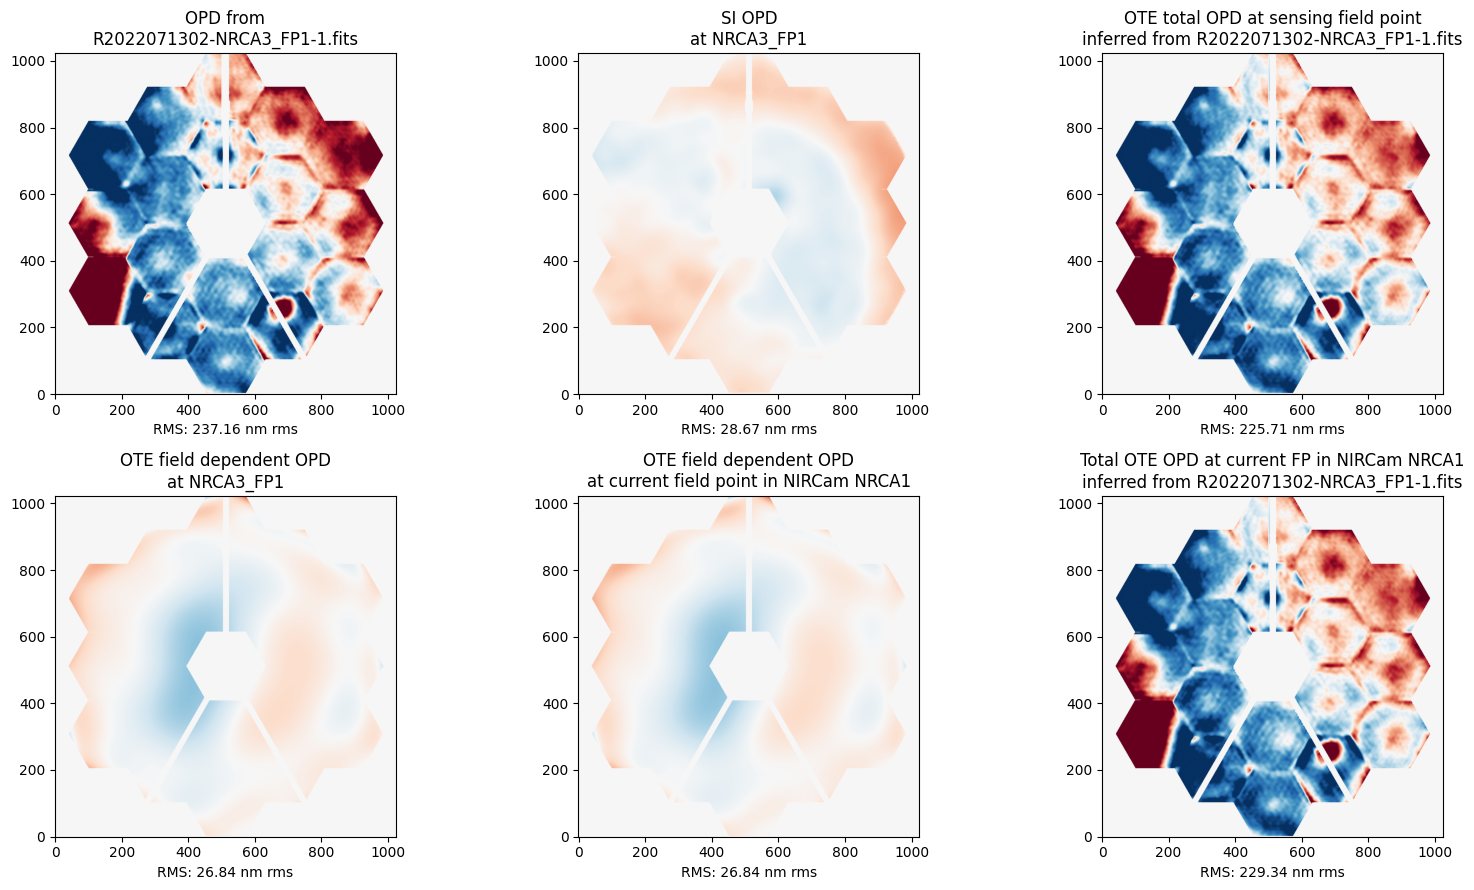

In [5]:
# for each date, load the wavefront measurement closest in time
# this one is after the impact, before the correction
nrc_j12.load_wss_opd_by_date('2022-07-12T00:00:00',plot=True)


MAST OPD query around UTC: 2022-07-16T00:00:00.000
                        MJD: 59776.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022071502-NRCA3_FP1-2.fits
	Date (MJD):	 59775.4519
	Delta time:	 -0.5481 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022071702-NRCA3_FP1-1.fits
	Date (MJD):	 59777.4424
	Delta time:	 1.4424 days
User requested choosing OPD time closest in time to 2022-07-16T00:00:00.000, which is R2022071502-NRCA3_FP1-2.fits, delta time -0.548 days
Importing and format-converting OPD from /home/meredithstone/data/stpsf-data/MAST_JWST_WSS_OPDs/R2022071502-NRCA3_FP1-2.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point (NRCA3_FP1)


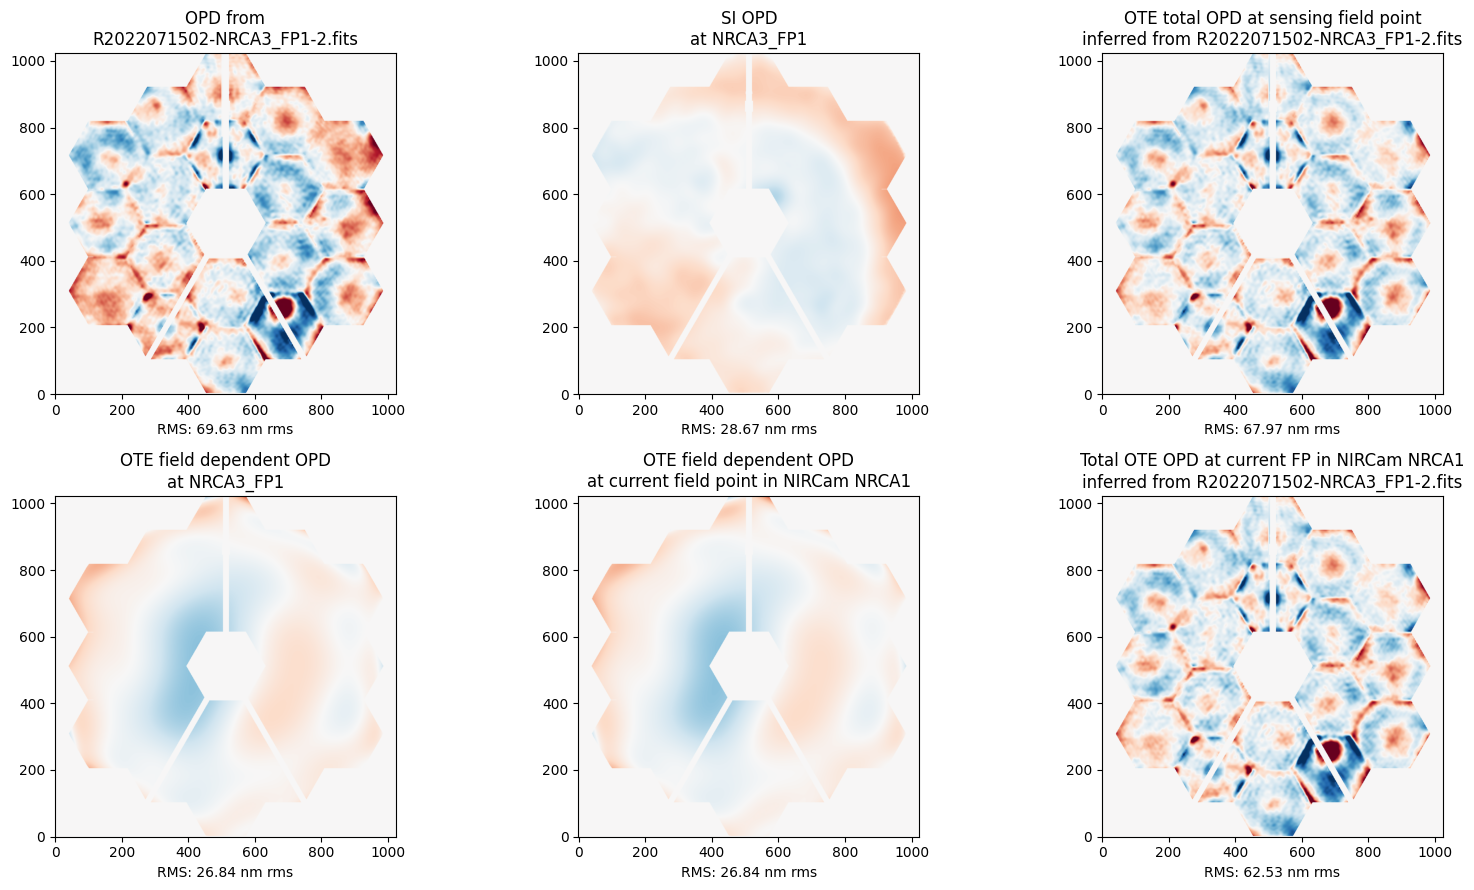

In [6]:
# and for comparison, July 16th after the on-orbit correction was applied
# it looks very different!
nrc_j16.load_wss_opd_by_date('2022-07-16T00:00:00',plot=True)

Comparing the two plots generated by STPSF, you can see that most (but not all!) of the wavefront error is corrected out. However, the telescope's actuators can't compensate for divots in the mirror, like the one at the lower right from the statistically-unlikely large micrometeroid impact in May 2022 that caused much consternation. Because of impacts like that, the JWST PSF will change slowly over time despite corrections.

In [7]:
# now calculate the PSF on each date:
psf_j12 = nrc_j12.calc_psf()
psf_j16 = nrc_j16.calc_psf()

The PSF object contains four extensions. The last one (extension 3, ``DET_DIST``) is the PSF, sampled at the detector level, with relevant instrumental distortion, etc. applied: it bears the closest resemblance to actual observations, but is noiseless. We'll be examining this PSF going forward.

In [8]:
psf_j12.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (640, 640)   float64   
  1  DET_SAMP      1 ImageHDU       142   (160, 160)   float64   
  2  OVERDIST      1 ImageHDU       194   (640, 640)   float64   
  3  DET_DIST      1 ImageHDU       195   (160, 160)   float64   


We'll display this extension of each PSF using a built-in STPSF function. Here's the NIRCam PSF before and after the correction.

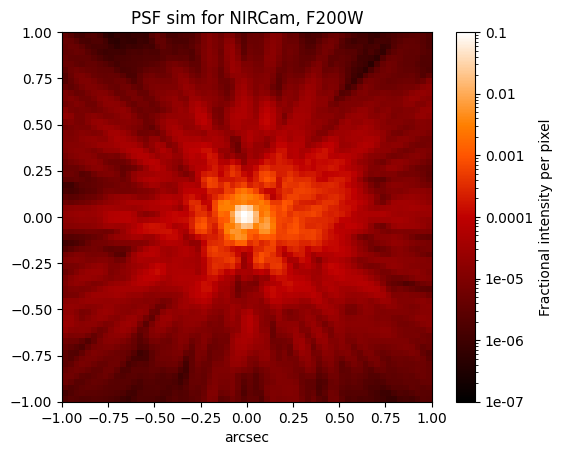

In [9]:
stpsf.display_psf(psf_j12, ext=3, imagecrop=2)

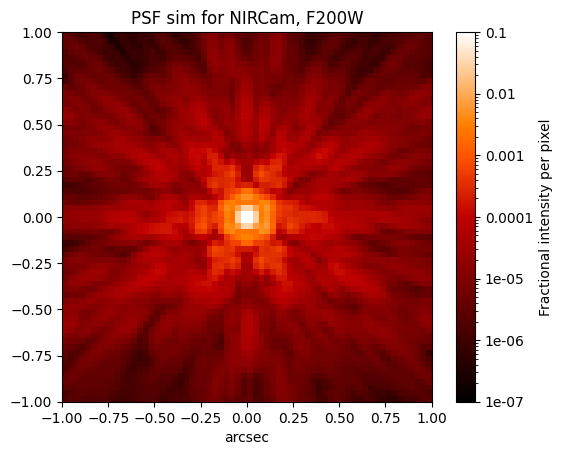

In [10]:
stpsf.display_psf(psf_j16, ext=3, imagecrop=2)

If you're familiar with the snowflake-like shape of JWST's inner PSF, you'll notice immediately that the PSF from July 12th looks quite distorted compared to July 16th. It's probably not even necessary to demonstrate, but we can plot the difference of the two. The colorbar on the below plot will make it look like the difference is a few parts per million, but you can do a MinMaxInterval instead to see that the difference is *much* more severe than that, especially near the center - more like 1-2%. For the science cases that PSF subtraction is used for, this is a significant fraction of the actual signal expected.

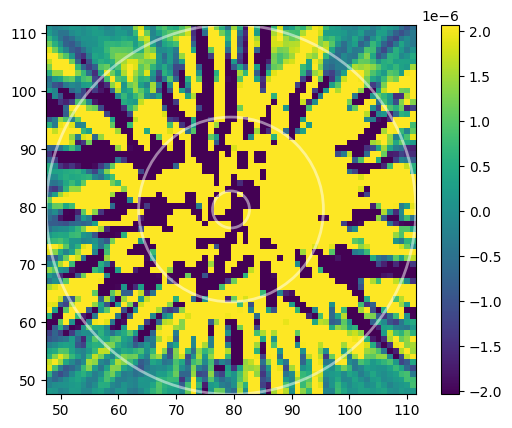

In [11]:
# circles of equal radius for plotting: 0.1, 0.5, and 1 arcsec
as01 = Circle((79.5, 79.5), radius=0.1/0.03125, ec='white', fc='None', lw=2, alpha=0.5)
as05 = Circle((79.5, 79.5), radius=0.5/0.03125, ec='white', fc='None', lw=2, alpha=0.5)
as1 = Circle((79.5, 79.5), radius=1/0.03125, ec='white', fc='None', lw=2, alpha=0.5)

diff = psf_j12[3].data - psf_j16[3].data
norm = ImageNormalize(diff, interval=ZScaleInterval(), stretch=LinearStretch())
fig, ax = plt.subplots()
psf = ax.imshow(diff, norm=norm)
ax.add_patch(as01)
ax.add_patch(as05)
ax.add_patch(as1)
plt.xlim(47.5, 111.5) # again, show inner 2 arcsec
plt.ylim(47.5, 111.5)
plt.colorbar(psf, ax=ax)

### Variation across detector

The JWST optical telescope element (OTE) is built to minimize optical aberrations across the field, but the instruments themselves introduce small intrinsic aberrations which cause the PSF to vary slightly across their detectors. Here, we'll simulate two NIRCam PSFs with the same filter and detector, but at very different positions on the detector, which is 2048x2048 pixels.

In [12]:
# initialize and set the filter as before
nrc_pos1 = stpsf.NIRCam()
nrc_pos2 = stpsf.NIRCam()
nrc_pos1.filter = 'F200W'; nrc_pos2.filter = 'F200W'

# explicitly set the detector used
nrc_pos1.detector = 'NRCB2'; nrc_pos2.detector = 'NRCB2' # the bottom-left short-wave detector, not that it matters
nrc_pos1.detector_position = (100, 100) # near the corner
nrc_pos2.detector_position = (1024, 1024) # near the center

In [13]:
# generate PSFs
psf_pos1 = nrc_pos1.calc_psf()
psf_pos2 = nrc_pos2.calc_psf()

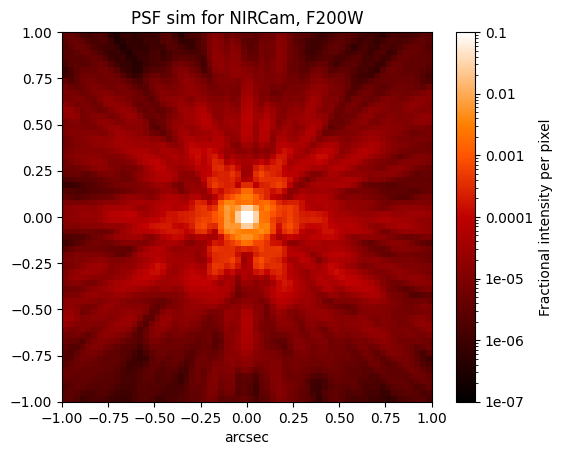

In [14]:
# and plot
stpsf.display_psf(psf_pos1, ext=3, imagecrop=2)

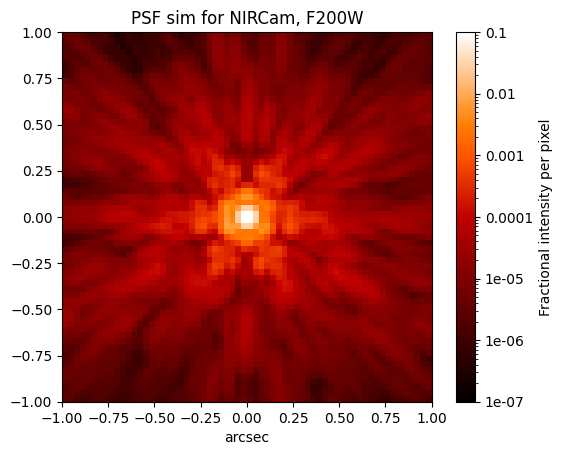

In [15]:
stpsf.display_psf(psf_pos2, ext=3, imagecrop=2)

Unlike the previous example, the PSFs look basically identical to the eye. But let's plot their difference, and we'll see once again that the aberrations are significant.

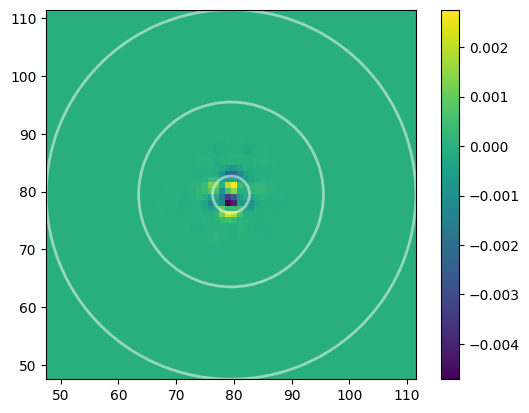

In [16]:
# circles of equal radius for plotting: 0.1, 0.5, and 1 arcsec
as01 = Circle((79.5, 79.5), radius=0.1/0.03125, ec='white', fc='None', lw=2, alpha=0.5)
as05 = Circle((79.5, 79.5), radius=0.5/0.03125, ec='white', fc='None', lw=2, alpha=0.5)
as1 = Circle((79.5, 79.5), radius=1/0.03125, ec='white', fc='None', lw=2, alpha=0.5)

diff = psf_pos1[3].data - psf_pos2[3].data
norm = ImageNormalize(diff, interval=ZScaleInterval(), stretch=LinearStretch())
fig, ax = plt.subplots()
psf = ax.imshow(diff)#, norm=norm)
ax.add_patch(as01)
ax.add_patch(as05)
ax.add_patch(as1)
plt.xlim(47.5, 111.5) # again, show inner 2 arcsec
plt.ylim(47.5, 111.5)
plt.colorbar(psf, ax=ax)

### Variation with spectral shape

In [17]:
wave = 1e-6*np.linspace(0.6, 2.3, 10) # wavelengths must be observable by the instrument being simulated 
                                      # otherwise will throw an error
flux_flat = np.ones(10) # our flat "quasar" spectrum
flux_rj = (-(wave*1e6)+5) / 2 # our declining Rayleigh-Jeans spectrum

# define the source dictionary to feed to STPSF
src_star = {'wavelengths': wave, 'weights': flux_rj}
src_qso = {'wavelengths': wave, 'weights': flux_flat}

In [18]:
nrc = stpsf.NIRCam()
psf_star = nrc.calc_psf(source=src_star)
psf_qso = nrc.calc_psf(source=src_qso)

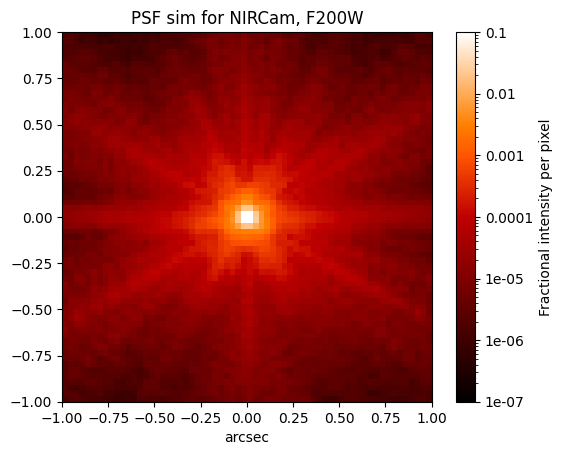

In [19]:
# take a look at inner 2 arcsec of quasar PSF:
stpsf.display_psf(psf_qso, ext=3, imagecrop=2)

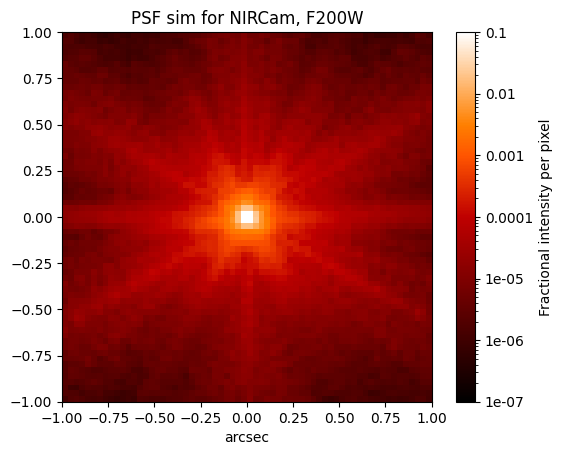

In [20]:
# and stellar PSF:
stpsf.display_psf(psf_star, ext=3, imagecrop=2)

The stellar and quasar PSFs look identical to the eye, but we'll examine their difference below to see that that's not the case, especially near the center.

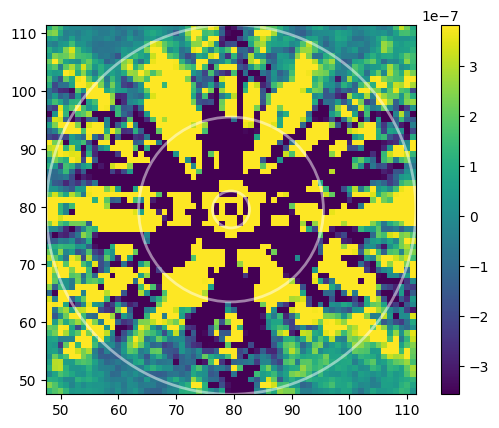

In [21]:
# circles of equal radius for plotting: 0.1, 0.5, and 1 arcsec
as01 = Circle((79.5, 79.5), radius=0.1/0.03125, ec='white', fc='None', lw=2, alpha=0.5)
as05 = Circle((79.5, 79.5), radius=0.5/0.03125, ec='white', fc='None', lw=2, alpha=0.5)
as1 = Circle((79.5, 79.5), radius=1/0.03125, ec='white', fc='None', lw=2, alpha=0.5)

diff = psf_qso[3].data - psf_star[3].data
norm = ImageNormalize(diff, interval=ZScaleInterval(), stretch=LinearStretch())
fig, ax = plt.subplots()
psf = ax.imshow(diff, norm=norm)
ax.add_patch(as01)
ax.add_patch(as05)
ax.add_patch(as1)
plt.xlim(47.5, 111.5) # again, show inner 2 arcsec
plt.ylim(47.5, 111.5)
plt.colorbar(psf, ax=ax)

The PSF of the star and quasar are not identical: the redder spectrum of the quasar broadens its PSF compared to the bluer star. In most regions, the difference is small (less than a part per million, see colorbar), but they are much larger in the center. By changing to a MinMaxInterval and regenerating the plot, you can see that the discrepancy is 1000x larger very near the center, and is not symmetrical (more negative than positive).